In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [3]:
import numpy as np
import pandas as pd
import itertools as it

# Hypothesis Testing and Bayesian Inference

## Probability and Inference

There is an important distinction between the study of probability and statistical inference, although both rely on the same fundamental principles.

**Probability Theory:**
1. Given a known random process with a particular distribution, what are the outcomes from that process?
1. Model $\rightarrow$ Data

**Statistical Inference:**
1. Given a known dataset, what is the underlying process and its distribution?
1. Data $\rightarrow$ Model

Statistical questions are generally what we will need to answer as data scientists. Although they can be thought of as the inverse of probability questions, they are in general ill-defined (i.e. our data will not always allow us to determine a unique model). However, we can make assumptions about the underlying probability model based on our knowledge of the problem and then use statistical tests to determine the correctness of our model.

Statistical inference is characterized by the fact that:
- Our dataset will typically be a *sample* taken from the *population* and we are trying to infer something about the population.
- Data will have errors or noise associated with how it was collected

*Hypothesis testing* and *Bayesian Inference* are two examples of methods for statistical inference.

## Hypothesis Testing

A statistical hypothesis is one which is testable based on data from a process than is modeled by a set of random variables. 

We are typically comparing two datasets, either:

1. Two observed datasets (and testing their similarity)
1. An observed dataset and a dataset generated from our proposed model (and again testing their similarity)

Then the standard approach is to generate two hypotheses:

1. **Alternative Hypothesis $H$:** The proposed relationship that we are investigating
1. **Null Hypothesis $H_0$:** That there is no relationship of the form of our proposition between the two datasets

### $p$-values and determining significance

To calculate which of the hypotheses is correct we follow these steps in the case of significance testing. Note that this is not the only way to do hypothesis testing 

1. We then choose our *statistical test* and a suitable *significance level*, $\alpha$.

1. The *$p$-value* is defined as the probability, given that the null hypothesis is true, that the result of our statistical test is equal to or greater than the actual observed result.

1. The relationship is then called *statistically significant* if the $p$-value is less than the significance level $(p \leq \alpha)$.

Mathematically we can write this in terms of the null hypothesis, $H_0$, for a the observed data, $X$, and a particular observation, $x$,

$$p = P(X \geq x \mid H_0)$$

### Interpreting $p$-values

We must take care when assessing $p$-values and choosing our significance level. The probability of rejecting the null hypothesis given that the null hypothesis is in fact true is given by:

$$P(\text{reject } H_0 \mid H_0) = P(p \leq \alpha \mid H_0) = \alpha$$

This would be a Type I Error or a False Positive.

We could also have a Type II Error or a False Negative, which would be the case of not rejecting the null hypothesis even though the alternative hypothesis is true. This would be given by:

$$P(\text{accept } H_0 \mid H) = P(p \geq \alpha \mid H) = \beta$$

The **precision** and **recall** metrics that we defined before are also applicable in the case of hypothesis testing. Or we can use **sensitivity** and **specificity**, the difference being that precision and recall are independent of True Negative results and are therefore better suited to many machine learning problems with large datasets.

Using the definitions of True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN) we can define the relationships between these metrics:

$$\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

$$\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} = 1 - \beta$$

$$\alpha = \frac{\text{FP}}{\text{TN} + \text{FP}} = 1 - \text{specificity}$$

$$\beta = \frac{\text{FN}}{\text{TP} + \text{FN}} = 1 - \text{sensitivity}$$

### Student's $t$-test

The $t$-test is a very common method for hypothesis testing. It is based on the $t$-distribution which arises from the sample estimate of the mean of a normally distributed population when the variance of the population is not known.

The $t$-test calculates a $t$ score, which in the case of comparing two means is given by:

$$t = \frac{\bar{X_1} - \bar{X_2}}{SE_{\bar{X_1} - \bar{X_2}}}$$

Where $SE$ is the standard error of the particular estimator we are using (the difference of the means in this case).

Our $t$ score follows the $t$-distribution, however, usually we want to convert this to a probability ($p$-value) by calculating the critical area under the probability density function.

*Note:* the same method can be applied to other statistical tests e.g. $\chi^2$-score, $F$-score, $z$-score etc.

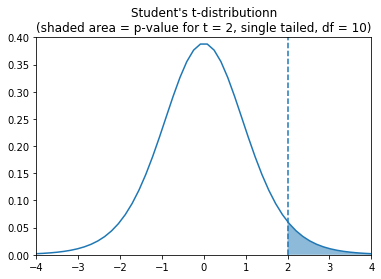

In [4]:
from scipy.stats import t

degrees_freedom = 10
x = np.linspace(-4, 4)
xf = np.linspace(2, 4)
plt.plot(x, t.pdf(x, degrees_freedom))
plt.axvline(x=2, ls='--')
plt.fill_between(xf, t.pdf(xf, degrees_freedom), alpha=0.5)
plt.axis([-4, 4, 0, 0.4])
plt.title("Student's t-distributionn\n(shaded area = p-value for t = 2, single tailed, df = 10)")

We can go through a simple example here using the Iris Plants Dataset and determining whether there is a statistically significant difference between the sepal widths of the different species. `scipy.stats` provides functions for various statistical tests including a $t$-test and calculates both $t$ scores and $p$-values for us.

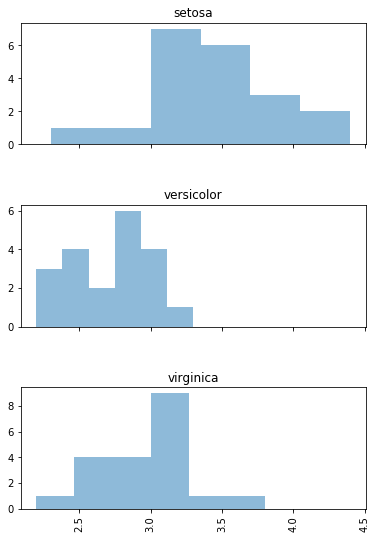

In [5]:
from scipy.stats import ttest_ind

# Load data
iris = sns.load_dataset('iris')
species = ['setosa', 'versicolor', 'virginica']
feature = 'sepal_width'

# Select only N samples from each species
N = 20
slist = []
for s in species:
    slist.append(iris[iris['species'] == s].sample(N, random_state=42))
iris_sample = pd.concat(slist)

# Plot histograms of the petal lengths
iris_sample.hist(column=feature, by='species', bins=6,
                 sharex=True, figsize=(6, 9), layout=(3, 1), alpha=0.5);

In [6]:
# Group by species and show stats
stats = iris_sample.groupby('species')[feature].describe()
stats

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,20.0,3.365,0.474924,2.3,3.000,3.4,3.625,4.4
versicolor,20.0,2.735,0.301357,2.2,2.500,2.8,2.925,3.3
virginica,20.0,2.920,0.366491,2.2,2.725,3.0,3.100,3.8


In [7]:
# Calculate t scores between different species
s_dict = {}
for s in species:
    s_dict[s] = iris_sample[iris_sample['species'] == s][feature]

stat_df = []
for i in it.combinations(species, 2):
    t, p = ttest_ind(s_dict[i[0]], s_dict[i[1]], equal_var=False)
    stat_df.append([i[0], i[1], t, p, p < 0.05])

pd.DataFrame(stat_df, columns=['species A',
                               'species B',
                               't-score', 'p-value', 'p < 0.05'])

,species A,species B,t-score,p-value,p < 0.05
0,setosa,versicolor,5.009092,0.000019,True
1,setosa,virginica,3.317440,0.002097,True
2,versicolor,virginica,-1.743687,0.089602,False


We can reject the null hypothesis in the first two cases but not for the last pair.

What happens if we adjust the number of samples $N$?

### Assumptions for $t$-tests

- Our samples are randomly generated from the population
- Samples are normally distributed
- Sample size is of reasonably large
- Means are independent of variance

## Bayesian Inference

### Bayesian statistics vs Frequentist statistics

There are two philosophical approaches to how we think about probability and statistics.


|                    | Frequentist                                   | Bayesian                                  |
|--------------------|:----------------------------------------------|:------------------------------------------|
| *Probability*      | Arises from the limiting frequency of event   | Plausibility of a proposition             |
| *Model Parameters* | Fixed based on the model                      | Unknown and described probabilistically   |
| *Data*             | Taken from repeatable random sampling         | Fixed and observed from realized sample   |
| *Prior*            | No prior assumptions                          | Include prior information                 |
| *Inference*        | Deduction from $P(X \mid H_0)$      | Induction from $P(\theta \mid X)$ using $P(\theta)$ |

*Bayesian inference* therefore uses probabilities for both hypotheses and data whereas *Frequentist inference* does not allows us to calculate the probability of a hypothesis.

Frequentist inference, and hypothesis testing using $p$-values as described above, has been the predominant method in the sciences during the 20th century. However, with the ability to deal with large datasets, machine learning, and more powerful computational methods, Bayesian methods are becoming more popular.

### Why Bayes?

Bayesian inference is very useful in data science for the following reasons:

1. Even if our dataset is small we can use prior information related to our problem e.g. evaluating a new advertising strategy with information about old strategies.
1. If we have a very high variance model, we can use priors as a way to regularize the model e.g. in NLP and sentiment analysis.
1. We may need an estimate of the likelihood of a particular model parameter rather than just the confidence of the hypothesis especially when dealing with a large number of features.

### Bayes' theorem

Bayes' theorem describes the probability of an event based on prior knowledge of conditions that might be related to the event. Given two events $A$ and $B$, we can write that:

$$P(A \mid B) = \frac{P(B \mid A)\; P(A)}{P(B)}$$

In the general case where $A$ is separable into parts, $\{A_i\}$, we can write:

$$P(A_i \mid B) = \frac{P(B \mid A_i)\; P(A_i)}{P(B)} = \frac{P(B \mid A_i)\; P(A_i)}{\sum_{j}{P(B \mid A_j)\; P(A_j)}}$$

And therefore we can also write a version for continuous random variables. As applied to inference, we are interested in testing a model with parameters, $\theta$, given a set of observed data points, $X$, and hyperparameters, $\alpha$.

$$p(\theta \mid X,\alpha) = \frac{p(X \mid \theta)\; p(\theta \mid \alpha)}{\int{p(X \mid \theta^\prime)\; p(\theta^\prime \mid \alpha)\; \text{d}\theta^\prime}}$$

### Definitions

- **Prior Distribution:** The probability of particular parameters without considering any data, $p(\theta \mid \alpha)$
- **Posterior Distribution:** The probability of particular parameters given the data, $p(\theta \mid X,\alpha)$
- **Likelihood:** The distribution of data conditional on its parameters, $p(X \mid \theta)$

In other words the posterior distribution is the likelihood multiplied by the prior and correctly normalized.

Note that if we assume a uniform prior, $p(\theta \mid \alpha) = 1$, then we can reduce to the Frequentist formalism.

### Conjugate priors

Generally our likelihood distribution will be well-defined by how we collected our data. However, we can then choose any prior distribution that we want depending on our knowledge of the situation.

This means that the integral of $p(X \mid \theta^\prime) p(\theta^\prime \mid \alpha)$ can very easily become impossible to compute analytically and would require numerical methods. This is one of the major reasons that Bayesian inference was not widely adopted before the advent of the computer.

However, for certain choices of prior, called **conjugate priors**, and associated likelihood functions there exist closed-form solutions for the posterior distribution, thus simplifying the algebra that we need to do.

Here are some common families of distributions and their conjugate priors:

| Likelihood function         | Conjugate Prior (and therefore Posterior)     |
|-----------------------------|:----------------------------------------------|
| Normal (known $\sigma^2$)   | Normal                                        |
| Normal (known $\mu$)        | Gamma                                         |
| Exponential                 | Gamma                                         |
| Bernoulli                   | Beta                                          |
| Binomial                    | Beta                                          |
| Poisson                     | Gamma                                         |

Here is a simple example using data that is a count of the number of successes, $x$, from 6 attempts at a particular event. We expect this to follow a binomial distribution with $n = 6$ therefore we can use:

- **Likelihood:** $\text{binomial}(n,p) \propto p^x (1-p)^{n-x}$
- **Conjugate prior:** $\text{beta}(\alpha, \beta) \propto p^{\alpha-1} (1-p)^{\beta-1}$

Since we can just obtain the form of the posterior by multiplying these terms we get:

$$\text{posterior} \propto p^x (1-p)^{n-x} p^{\alpha-1} (1-p)^{\beta-1} \\ = p^{x+\alpha-1} (1-p)^{n-x+\beta-1}$$


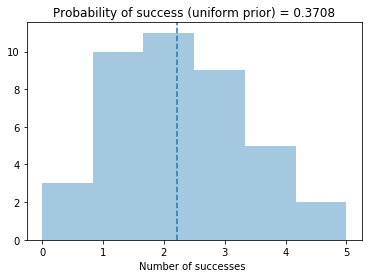

In [8]:
from scipy.stats import binom
from scipy.stats import beta

data = np.array([2, 4, 3, 3, 1, 4, 1, 4, 3, 3, 0, 5, 4, 1, 1, 1, 2, 2, 2, 2,
                 2, 2, 3, 1, 2, 3, 0, 3, 1, 1, 4, 5, 3, 2, 1, 3, 2, 1, 2, 0])

n = 6
trials = len(data) * n
xm = data.mean()
xsuccess = data.sum()
sns.distplot(data, bins=6, kde=False, label='Data')
plt.axvline(x=xm, ls='--')
plt.title("Probability of success (uniform prior) = {:.4f}".format(xm / n))
plt.xlabel("Number of successes ");

But what if we want to include a prior?

We can choose our beta function depending on information we already have about our problem, for example, let's say that we had performed this experiment several times before and typically obtained a success rate of 5/6. Is our current batch abnormally low? Can we update our prior to give a more realistic estimate of the posterior?

In [9]:
from ipywidgets import *

# Previous success rate
p = 5. / n

def update(prev_trials=100):

    # Conjugate Prior
    a = p * prev_trials
    b = (1 - p) * prev_trials
    prior = beta(a, b)

    # Calculate Posterior
    posterior = beta(xsuccess + a, trials - xsuccess + b)

    x = np.arange(0, 1.0, 0.001)
    sns.distplot(data / float(n), bins=6, kde=False, label='Data')
    plt.axvline(x=xm / n, ls='--')
    plt.plot(x, prior.pdf(x), label='Prior')
    plt.plot(x, posterior.pdf(x), label='Posterior')
    plt.axvline(x=posterior.mean(), c='g', ls='--')
    plt.legend()
    plt.xlabel("Probability of success from 6 attempts")
    plt.axis([0, 1, 0, 15])
    plt.show()
    return

In [10]:
widgets.interact(update, prev_trials=[0, 5, 10, 100, 1000]);

### Posterior sampling

If it is the case that we *cannot* find a suitable conjugate prior then we can instead use *posterior sampling*. Often we do not need the full form of the posterior distribution but only summary statistics about it, for example its mean and variance. Therefore, if we can *exactly sample* from the posterior distribution we can estimate these quantities without resorting to complex numerical integration.

A common way to perform this sampling is by using *Monte Carlo Markov Chain* (MCMC) methods such as *Gibbs Sampling*. In MCMC we generate a Markov chain in such as way that the stationary state of the system produces samples with a distribution equal to the distribution we are interested in.

We can use the `pymc3` package to do MCMC sampling. Let's apply it to the previous dataset assuming that we do not know about conjugate priors and therefore cannot calculate the posterior directly.

In [11]:
import pymc3 as pm

# Previous success rate and trials
p = 5. / n
prev_trials = 100

# Conjugate Prior
a = p * prev_trials
b = (1 - p) * prev_trials
prior = beta(a, b)

# Create a statistical model
with pm.Model() as model:

    # Generate prior as before
    pr = pm.Beta('p', alpha=a, beta=b)

    # Likelihood function with our observed dataset with the correct prior
    y = pm.Binomial('y', n=n, p=pr, observed=data)

    # Use MAP estimate (optimization) as the initial state for the MCMC
    start = pm.find_MAP()

    # Choose sampler (Metropolis) and run
    step = pm.Metropolis()
    trace = pm.sample(5000, step, start=start,
                      random_seed=42, progressbar=True)

Optimization terminated successfully.
         Current function value: 98.398943
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|██████████| 5500/5500 [00:01<00:00, 3765.18it/s]


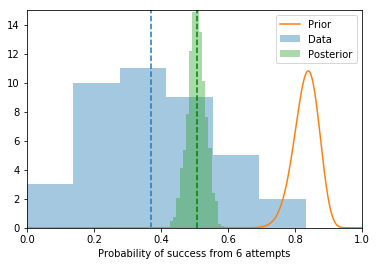

In [12]:
x = np.arange(0, 1.0, 0.001)
sns.distplot(data / float(n), bins=6, kde=False, label='Data')
plt.axvline(x=xm / n, ls='--')

plt.plot(x, prior.pdf(x), label='Prior')
sns.distplot(trace['p'], bins=20, norm_hist=True, kde=False, label='Posterior')
plt.axvline(x=np.mean(trace['p']), c='g', ls='--')
plt.legend()
plt.xlabel("Probability of success from 6 attempts")
plt.axis([0, 1, 0, 15])
plt.show()

As expected we get the same result but now our posterior distribution is a sample of 5000 rather than the analytic form derived above, but this approach allows us to use any prior we want. 